In [ ]:
!pip install trieste==1.2.0, plotly==5.17.0, matplotlib==3.8.0     # using a virtual environment is recommended

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)


In [2]:
import math
import gpflow
import random
import numpy as np
import matplotlib.pyplot as plt

import trieste
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.data import Dataset
from trieste.models import TrainableModelStack
from trieste.models.gpflow import build_gpr, GaussianProcessRegression
from trieste.space import Box, SearchSpace
from trieste.objectives.utils import mk_observer
from trieste.types import TensorType

### Objective and safety functions

In [4]:
from trieste.objectives import ScaledBranin, Hartmann3
hartmann_3 = Hartmann3.objective

def obj_hartmann_3(x:TensorType) -> TensorType:
    obj_tensor = hartmann_3(x)
    obj_tensor = tf.squeeze(obj_tensor, -1)
    return obj_tensor

def g_syn_3D(x: TensorType) -> TensorType:
    x0 = x[..., :1]
    x1 = x[..., 1:2]
    x2 = x[..., 2:]
    safety_tensor = -( x0 + x1**2 + x2**3)
    return tf.squeeze(safety_tensor, -1)
    
obj = obj_hartmann_3
safety = g_syn_3D


### Search space

In [5]:
def comb_funcs(x: TensorType) -> TensorType:
    return tf.stack([obj(x), safety(x)], axis = -1)

def comb_funcs_plot(x:TensorType) -> TensorType:
    return -comb_funcs(x)

observer = mk_observer(
    comb_funcs
)

num_objective = 2

data_dim = 3
data_num_per_dim = tf.constant(50)

mins = [0, 0, 0]
maxs = [1, 1, 1]

search_space = Box(mins, maxs)

### Build Gaussian Process models

In [6]:
import tensorflow_probability as tfp

def build_model(data, variance):
    variance = tf.math.reduce_variance(data.observations)
    kernel = gpflow.kernels.Matern52(variance=variance, lengthscales=[.2, .2, .2])
    prior_scale = tf.cast(1.0, dtype=tf.float64)
    kernel.variance.prior = tfp.distributions.LogNormal(
        tf.cast(variance, dtype=tf.float64), prior_scale
    )
    
    kernel.lengthscales.prior = tfp.distributions.LogNormal(
        tf.math.log(kernel.lengthscales), prior_scale
    )
    
    gpr = gpflow.models.GPR(data.astuple(), kernel, noise_variance=1e-5)
    gpflow.set_trainable(gpr.likelihood, False)
    return GaussianProcessRegression(gpr, num_kernel_samples=10)

def build_stacked_independent_objectives_model(
    data: Dataset, num_output: int, search_space: SearchSpace, variances = [1, 1, 1]
) -> TrainableModelStack:
    gprs = []
    for idx in range(num_output):
        single_obj_data = Dataset(
            data.query_points, tf.gather(data.observations, [idx], axis=1)
        )
        gprs.append((build_model(single_obj_data, variances[idx]), 1))

    return TrainableModelStack(*gprs)

### M-SafeOpt (for finding global safe optimum)

[Memory efficient implementation]

In [27]:
h = tf.constant(2.0, tf.float64)   #safety threshold

beta_f = tf.constant(3.0, tf.float64)   #scaling factor for confidence interval of GP_f
beta_g = tf.constant(3.0, tf.float64)   #scaling factor for confidence interval of GP_g

from trieste.acquisition import (
    SingleModelAcquisitionBuilder,
    ExpectedImprovement,
    Product,
)

from trieste.data import Dataset
from trieste.models import ProbabilisticModel
from trieste.acquisition.rule import AcquisitionRule
from trieste.types import TensorType
from typing import Optional
from collections.abc import Mapping
import itertools

class MSafeOPTMemEff(AcquisitionRule[TensorType, SearchSpace, ProbabilisticModel]):
    def __init__(self, num_query_points: int = 1):
        if num_query_points <= 0:
            raise ValueError(
                f"Number of query points must be greater than 0, got {num_query_points}"
            )
        self._num_query_points = num_query_points

    def acquire(
        self,
        search_space: SearchSpace,
        models: Mapping[str, ProbabilisticModel],
        datasets: Optional[Mapping[str, Dataset]] = None,
    ) -> TensorType:
        
        def create_grid_generator(shape, box_lower, box_upper):
            for i in itertools.product(*[box_lower[x]+range(shape[x])*(box_upper[x]-box_lower[x])/(shape[x]-1) for x in range(1, len(shape))]):
                yield [[x/(shape[0]-1)]+list(i) for x in range(shape[0])]
                
        @tf.function(reduce_retracing=True)
        def acq_query_point():
            box_lower = search_space.lower
            box_upper = search_space.upper   
            
            num_dims = box_lower.shape[0]
            num_per_dim = 50
                                        
            best_sample = tf.constant(box_lower, tf.float64)
            max_interval = tf.constant(0, tf.float64)
            max_safe_LCB = tf.constant(-np.inf, tf.float64)
            
            shape = [num_per_dim]*num_dims
            grid_generator = tf.data.Dataset.from_generator(create_grid_generator, args = (shape, box_lower, box_upper), 
                                                            output_signature = (tf.TensorSpec(shape=(num_per_dim, len(shape),), dtype=tf.float64)))
            
            grid_generator = grid_generator.prefetch(tf.data.AUTOTUNE).cache()
            
            for x in grid_generator:
                mean, var = model.predict(x)
                stddev = tf.math.sqrt(var)

                mean_f = tf.reshape(mean[:,0], [num_per_dim, 1])
                mean_g = tf.reshape(mean[:,1], [num_per_dim, 1])
                                    
                stddev_f = tf.reshape(stddev[:,0], [num_per_dim, 1])
                stddev_g = tf.reshape(stddev[:,1], [num_per_dim, 1])
                
                UCB_g = - mean_g + beta_g * stddev_g  # upper confidence bound
                LCB_f = - mean_f - beta_f * stddev_f  # lower confidence bound
                
                mask_less_g = tf.reshape(tf.math.less_equal(UCB_g, h), [num_per_dim])  # mask for all points with UCB <= h
                mask_more_g = tf.reshape(tf.math.greater(UCB_g, h), [num_per_dim, 1])  # mask for all points with UCB > h
                                
                mask_zero_g = tf.reshape(tf.one_hot(indices=[0], depth=num_per_dim, on_value=1.0, off_value=0.0), [num_per_dim, 1])  
                mask_zero_g = tf.cast(mask_zero_g, tf.bool)

                mask_zero_g = tf.reshape(tf.math.logical_and(mask_more_g, mask_zero_g),
                                   [num_per_dim, 1])  # mask for all points with s=0 and UCB > h
                                      
                mask_safe_g = tf.reshape(mask_less_g,  [num_per_dim, 1])
                mask_safe_g = tf.math.logical_or(mask_safe_g, mask_zero_g)

                LCB_f_safe =  tf.math.multiply(LCB_f+tf.constant(100000, mean.dtype), tf.cast(mask_safe_g, mean.dtype))
                LCB_f_safe_max = tf.reduce_max(LCB_f_safe) - tf.constant(100000, mean.dtype)

                max_safe_LCB = tf.cond(max_safe_LCB < LCB_f_safe_max, lambda: LCB_f_safe_max, lambda: max_safe_LCB)
                            
            for x in grid_generator:
                mean, var = model.predict(x)
                stddev = tf.math.sqrt(var)
                            
                mean_f = tf.reshape(mean[:,0], [mean.shape[0], 1])
                mean_g = tf.reshape(mean[:,1], [mean.shape[0], 1])
                                    
                stddev_f = tf.reshape(stddev[:,0], [mean.shape[0], 1])
                stddev_g = tf.reshape(stddev[:,1], [mean.shape[0], 1])
                
                UCB_f = - mean_f + beta_f * stddev_f  # upper confidence bound
                UCB_g = - mean_g + beta_g * stddev_g  # upper confidence bound
                LCB_f = - mean_f - beta_f * stddev_f  # lower confidence bound
                LCB_g = - mean_g - beta_g * stddev_g  # lower confidence bound
                
                mask_less_g = tf.reshape(tf.math.less_equal(UCB_g, h), [mean.shape[0]])  # mask for all points with UCB <= h
                mask_more_g = tf.reshape(tf.math.greater(UCB_g, h), [mean.shape[0], 1])  # mask for all points with UCB > h
                   
                mask_zero_g = tf.reshape(tf.one_hot(indices=[0], depth=num_per_dim, on_value=1, off_value=0), [num_per_dim, 1])  
                mask_zero_g = tf.cast(mask_zero_g, tf.bool)
                
                mask_zero_g = tf.reshape(tf.math.logical_and(mask_more_g, mask_zero_g), [mean.shape[0], 1])  # mask for all points with s=0 and UCB > h
                                      
                mask_safe_g = tf.reshape(mask_less_g,  [mean.shape[0], 1])
                mask_safe_g = tf.math.logical_or(mask_safe_g, mask_zero_g)
        
                mask_less_g = tf.reshape(mask_less_g, [mean.shape[0], 1])
        
                mask_combined_g = tf.reshape(tf.math.logical_or(mask_less_g, mask_zero_g), [mean.shape[0]])
                mask_combined_g = tf.reshape(mask_combined_g, [1, num_per_dim])
                true_indices_g = tf.math.argmax(tf.reverse(mask_combined_g, [-1]), axis=-1)
                const_g = (num_per_dim - 1) * tf.ones(1, tf.int64)
                true_indices_g = tf.constant(num_per_dim-1, tf.int64) - true_indices_g
                mask_final_g = tf.zeros([1, num_per_dim], dtype=tf.int64)
                mask_final_g = tf.tensor_scatter_nd_add(mask_final_g,
                                                      tf.stack([tf.range(1, dtype=tf.int64), true_indices_g], axis=1),
                                                      tf.ones(1, dtype=tf.int64))
                
                safe_UCB_f = tf.math.multiply(tf.cast(mask_safe_g, tf.float64), UCB_f + tf.constant(100000, mean.dtype))
                safe_UCB_f = tf.reshape(safe_UCB_f, [1, num_per_dim])
                max_values = tf.reduce_max(safe_UCB_f, axis = -1, keepdims=True)
                mask_max_f = tf.greater_equal(safe_UCB_f, max_values)
                max_values = max_values - tf.constant(100000, mean.dtype)
        
                mask_final_g = tf.reshape(mask_final_g, [mean.shape[0], 1])
                
                # Eliminate suboptimal x's, and Limit expansion if suboptimal
                input_s = tf.reshape(x[:, 0], [mean.shape[0], 1])
                input_s_boundary = tf.math.multiply(input_s, tf.cast(mask_final_g, mean.dtype))
                input_s_boundary = tf.reshape(input_s_boundary, [1, num_per_dim])
                input_s_boundary = tf.reduce_max(input_s_boundary, axis = -1, keepdims=True)
                
                input_s_boundary_tiled = tf.tile(input_s_boundary,  [1 , num_per_dim])
                input_s_diff = tf.reshape(input_s, [1, num_per_dim]) - input_s_boundary_tiled
                
                LCB_g_boundary = tf.math.multiply(LCB_g + tf.constant(100000, mean.dtype), tf.cast(mask_final_g, mean.dtype))
                LCB_g_boundary = tf.reshape(LCB_g_boundary, [1, num_per_dim])
                LCB_g_boundary = tf.reduce_max(LCB_g_boundary, axis = -1 , keepdims=True) - tf.constant(100000, mean.dtype)
                LCB_g_boundary = tf.tile(LCB_g_boundary,  [1,num_per_dim])
                pessimistic_LCB_g = LCB_g_boundary + l_g*input_s_diff
                pessimistic_mask_g = tf.less_equal(pessimistic_LCB_g, h)
                
                UCB_f_boundary =  tf.math.multiply(UCB_f + tf.constant(100000, mean.dtype), tf.cast(mask_final_g, mean.dtype))
                UCB_f_boundary = tf.reshape(UCB_f_boundary, [1, num_per_dim])
                UCB_f_boundary = tf.reduce_max(UCB_f_boundary, axis = -1, keepdims=True) - tf.constant(100000, mean.dtype)
                UCB_f_boundary = tf.tile(UCB_f_boundary,  [1,num_per_dim])
                optimistic_UCB_f = UCB_f_boundary + L_f*input_s_diff
                optimistic_UCB_f_masked = tf.math.multiply(optimistic_UCB_f+ tf.constant(100000, mean.dtype), tf.cast(pessimistic_mask_g, mean.dtype))
                optimistic_UCB_f_max = tf.reduce_max(optimistic_UCB_f_masked, axis = -1, keepdims=True)-tf.constant(100000, mean.dtype)
                
                LCB_f_safe_max = max_safe_LCB
                
                expd_mask = tf.greater(optimistic_UCB_f_max, LCB_f_safe_max)
                expd_mask = tf.tile(expd_mask,[1, num_per_dim])
                expd_mask = tf.reshape(expd_mask, [mean.shape[0], 1])
                            
                elim_mask = tf.greater(max_values, LCB_f_safe_max)
                elim_mask = tf.tile(elim_mask, [1, num_per_dim])
                elim_mask = tf.reshape(elim_mask, [mean.shape[0], 1])
        
                elim_mask = tf.math.logical_or(elim_mask, expd_mask)       
                
                mask_final_g = tf.math.logical_and(tf.cast(mask_final_g, tf.bool), elim_mask)
                mask_final_g = tf.math.logical_and(tf.cast(mask_final_g, tf.bool), expd_mask)        

                mask_max_f = tf.reshape(mask_max_f, [mean.shape[0], 1])
                mask_max_f = tf.math.logical_and(mask_max_f, elim_mask)
                mask_final_f = tf.math.logical_or(tf.cast(mask_max_f, tf.bool), tf.cast(mask_final_g, tf.bool))
                                
                max_interval_f = beta_f * tf.math.multiply(tf.reshape(stddev_f, [stddev.shape[0], 1]),
                                        tf.cast(mask_final_f, mean.dtype))
                
                max_interval_g = beta_g * tf.math.multiply(tf.reshape(stddev_g, [stddev.shape[0], 1]),
                                        tf.cast(tf.reshape(mask_final_g, [stddev.shape[0], 1]), mean.dtype))

                curr_max_f = tf.reduce_max(max_interval_f)
                max_interval = tf.cond(curr_max_f >= max_interval, lambda: curr_max_f, lambda: max_interval)
                best_sample = tf.cond(curr_max_f >= max_interval, lambda: tf.gather(x, tf.where(max_interval_f == curr_max_f)[0,0]), lambda: best_sample)

                curr_max_g = tf.reduce_max(max_interval_g)
                max_interval = tf.cond(curr_max_g >= max_interval, lambda: curr_max_g, lambda: max_interval)
                best_sample = tf.cond(curr_max_g >= max_interval, lambda: tf.gather(x, tf.where(max_interval_g == curr_max_g)[0,0]), lambda: best_sample)

            return tf.reshape(best_sample, (1, num_dims))
        
        return acq_query_point()


### Run safe Bayesian optimization

In [28]:
rule = MSafeOPTMemEff()

L_f = tf.constant(1.9, tf.float64)  #hartmann_3
l_g = tf.constant(1, tf.float64)  #g_syn_3D

In [29]:
from trieste.ask_tell_optimization import AskTellOptimizer

num_runs = 1
num_steps = 50

for num_run in range(1, num_runs+1):

    num_initial_points = 2
    initial_query_points = tf.constant([[0.0, maxs[0]*random.random(), maxs[1]*random.random()], [0.0, maxs[0]*random.random(), maxs[1]*random.random()]], dtype=tf.float64)
    initial_data = observer(initial_query_points)
    
    model = build_stacked_independent_objectives_model(
        initial_data, num_objective, search_space
    )

    ask_tell = AskTellOptimizer(search_space, initial_data, model, acquisition_rule = rule)
    pred_means = []
    pred_vars = []    
    dataset = initial_data

    for step in range(1, num_steps + 1):
        print(f"Run #{num_run}: Step #{step}")
        new_point = ask_tell.ask()
        new_data_point = observer(new_point)
        dataset = dataset + new_data_point
        ask_tell.tell(dataset)       


Run #1: Step #1
Run #1: Step #2
Run #1: Step #3
Run #1: Step #4
Run #1: Step #5
Run #1: Step #6
Run #1: Step #7
Run #1: Step #8
Run #1: Step #9
Run #1: Step #10
Run #1: Step #11
Run #1: Step #12
Run #1: Step #13
Run #1: Step #14
Run #1: Step #15
Run #1: Step #16
Run #1: Step #17
Run #1: Step #18
Run #1: Step #19
Run #1: Step #20
Run #1: Step #21
Run #1: Step #22
Run #1: Step #23
Run #1: Step #24
Run #1: Step #25
Run #1: Step #26
Run #1: Step #27
Run #1: Step #28
Run #1: Step #29
Run #1: Step #30
Run #1: Step #31
Run #1: Step #32
Run #1: Step #33
Run #1: Step #34
Run #1: Step #35
Run #1: Step #36
Run #1: Step #37
Run #1: Step #38
Run #1: Step #39
Run #1: Step #40
Run #1: Step #41
Run #1: Step #42
Run #1: Step #43
Run #1: Step #44
Run #1: Step #45
Run #1: Step #46
Run #1: Step #47
Run #1: Step #48
Run #1: Step #49
Run #1: Step #50


### Plot cumulative regret: $R_t/t$

In [30]:
query_points = dataset.query_points.numpy()[2:]
observations = dataset.observations.numpy()[2:]

max_obj_value = 3.86278     # https://www.sfu.ca/~ssurjano/hart3.html

Text(0, 0.5, '$R_t /t$')

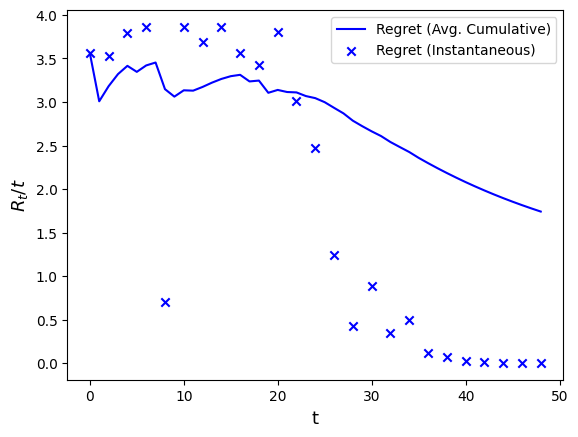

In [36]:
def plot_cumulative_regret(
    obs_values,
    ax,
    label,
    obs_every = 2,
    show_obs=False,
    c = "blue",
):
    cum_values = np.cumsum(obs_values)
    cum_values_t = [cum_values[i]/(i+1) for i in range(len(obs_values))]
    ax.plot(cum_values_t, color=c, label=label + " (Avg. Cumulative)")
        
    if show_obs:
        obs_values = np.array(obs_values)
        ax.scatter(range(0,obs_values.shape[0], obs_every), obs_values[0::obs_every], c=c, marker='x', label=label+" (Instantaneous)")

suboptimality = []
obs_obj_values = observations[:, 0]
for i in range(obs_obj_values.shape[0]-1):
    curr_suboptimality = max_obj_value + obs_obj_values[i]
    suboptimality += [curr_suboptimality]
    
_, ax = plt.subplots(1, 1)

plot_cumulative_regret(
    suboptimality, ax, label = "Regret", show_obs = True
)

ax.legend(loc='upper right')
ax.set_xlabel("t",fontsize = 13)
ax.set_ylabel(r"$R_t/t$",fontsize = 13)